# Proyecto: Predicción de la cancelación de clientes

## Descripción general

El objetivo ceel proyecto es predecir la probabilidad de cancelación de los clientes de la empresa **Interconnect**.

**Métrica principal:** AUC-ROC  
**Métrica adicional:** Accuracy  
**Variable objetivo:** `churn` (1 = canceló, 0 = activo)

## 1. Exploración y limpieza de datos

Explorar y combinar los datos necesarios de los archivos (contract.cvs, personal.csv, internet.csv, phone.csv) utilizando customerID.

Corregir valores  nulos, duplicados, inconsistencias y tipos de datos.

### 1.1 Exploración



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

contract = pd.read_csv('datasets/final_provider/contract.csv')
personal = pd.read_csv('datasets/final_provider/personal.csv')
internet = pd.read_csv('datasets/final_provider/internet.csv')
phone = pd.read_csv('datasets/final_provider/phone.csv')

pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_theme(palette='pastel')

for name, df in {'contract':contract, 'personal':personal, 'internet':internet, 'phone':phone}.items():
    print(f'\n{name.upper()} shape: {df.shape}')
    display(df.head())


CONTRACT shape: (7043, 8)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



PERSONAL shape: (7043, 5)


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



INTERNET shape: (5517, 8)


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



PHONE shape: (6361, 2)


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [2]:
print(contract.info())
print()
print(personal.info())
print()
print(internet.info())
print()
print(phone.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object


### 1.2 Limpieza y unificación
 - Unión de todas las tablas por 'customerID'
 - Crear la variable 'churn' con la columna 'EndDate'
 - Revisar los duplicados y valores ausentes

In [3]:
contract['churn'] = contract['EndDate'].apply(lambda x: 0 if x == 'No' else 1)
df = contract.merge(personal, on='customerID', how='left').merge(internet, on='customerID', how='left').merge(phone, on='customerID', how='left')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   churn             7043 non-null   int64  
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [4]:
#Convertir las fechas a tipo datetime, para después sacar información de ellas
df['BeginDate'] = pd.to_datetime(df['BeginDate'], errors='coerce')
df['EndDate'] = pd.to_datetime(df['EndDate'].replace('No', np.nan), errors='coerce')

#Las numéricas convertirlas a float en vez de object
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace({'': np.nan, ' ': np.nan}), errors='coerce')
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')

#Las variables que son binarias en convertirlas justo a 0 y 1 para su mejor interpretación (manteniendo NaN donde sea necesario)
binary_cols = [
    'PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'MultipleLines'
]
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].replace({'Yes': 1, 'No': 0})

df['SeniorCitizen'] = df['SeniorCitizen'].fillna(0).astype(int)
df['SeniorCitizen'] = df['SeniorCitizen'].clip(0,1)
display(df.sample(5))

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\3929086697.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'Yes': 1, 'No': 0})


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
3024,8735-NBLWT,2019-05-01,NaT,Month-to-month,0,Mailed check,20.40,184.10,0,Male,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1363,3084-DOWLE,2014-02-01,NaT,Two year,0,Bank transfer (automatic),92.00,6474.40,0,Female,0,1,0,DSL,1.0,1.0,1.0,1.0,1.0,1.0,1.0
848,9778-OGKQZ,2014-02-01,NaT,Two year,1,Credit card (automatic),92.00,6782.15,0,Male,0,1,0,DSL,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5112,1383-EZRWL,2019-06-01,2020-01-01,Month-to-month,0,Mailed check,20.05,164.85,1,Female,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3646,9738-QLWTP,2016-11-01,NaT,One year,0,Electronic check,81.90,3219.75,0,Male,0,0,0,Fiber optic,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [5]:
# A partir de las fechas de inicio y cancelación saber la duración del contrato
# Para el caso de lo clientes que no han cancelado, se calculará el tiempo de contrato contando cómo fecha máxima
# la fecha última de contrato (max) de BeginDate, para tomar las fechas del dataset

max_date = df['BeginDate'].max()
#print(df['BeginDate'].min())
#print(max_date)

df['EndDate_filled'] = df['EndDate'].fillna(max_date)
df['tenure_months'] = ((df['EndDate_filled'] - df['BeginDate']) / np.timedelta64(30, 'D')).round()
df['tenure_months'] = df['tenure_months'].fillna(0).clip(lower=0).astype(int)

In [6]:
df.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,EndDate_filled,tenure_months
4361,8680-CGLTP,2017-09-01,NaT,One year,1,Electronic check,58.75,1696.20,0,Male,0,0,0,DSL,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2020-02-01,29
6393,3466-RITXD,2017-12-01,NaT,Month-to-month,1,Credit card (automatic),92.40,2349.80,0,Male,0,0,0,Fiber optic,1.0,1.0,0.0,0.0,1.0,0.0,1.0,2020-02-01,26
943,6115-ZTBFQ,2014-02-01,NaT,Two year,0,Bank transfer (automatic),65.50,4919.70,0,Female,0,1,0,DSL,1.0,1.0,1.0,1.0,1.0,1.0,NaN,2020-02-01,73
2882,6652-YFFJO,2019-03-01,NaT,Month-to-month,1,Electronic check,64.90,716.10,0,Female,0,0,0,DSL,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2020-02-01,11
6152,7562-GSUHK,2018-07-01,2019-11-01,Month-to-month,1,Credit card (automatic),93.20,1573.70,1,Female,0,0,0,Fiber optic,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2019-11-01,16
3348,2172-EJXVF,2014-03-01,NaT,One year,1,Electronic check,105.90,7521.95,0,Female,1,0,0,Fiber optic,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2020-02-01,72
1682,9225-BZLNZ,2014-02-01,NaT,Two year,1,Electronic check,85.25,6083.10,0,Male,0,1,0,DSL,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2020-02-01,73
1423,0680-DFNNY,2018-10-01,2020-01-01,Month-to-month,1,Electronic check,101.10,1504.05,1,Male,0,1,0,Fiber optic,0.0,0.0,1.0,0.0,1.0,1.0,1.0,2020-01-01,15
3952,9861-PDSZP,2014-02-01,NaT,Two year,1,Credit card (automatic),108.05,7806.60,0,Female,0,0,0,Fiber optic,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2020-02-01,73
6356,3587-PMCOY,2019-04-01,NaT,One year,1,Electronic check,98.90,1064.95,0,Male,0,0,0,Fiber optic,1.0,0.0,1.0,0.0,1.0,1.0,0.0,2020-02-01,10


In [7]:
print('Tipos de datos')
print(df.dtypes)

print()
print('Conteo de nulos por columna')
print(df.isna().sum().sort_values(ascending=False))

# Duplicados por customerID
dup_count = df.duplicated(subset=['customerID']).sum() if 'customerID' in df.columns else 0
print(f'Duplicados por customerID: {dup_count} ===')

Tipos de datos
customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling             int64
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
churn                        int64
gender                      object
SeniorCitizen                int64
Partner                      int64
Dependents                   int64
InternetService             object
OnlineSecurity             float64
OnlineBackup               float64
DeviceProtection           float64
TechSupport                float64
StreamingTV                float64
StreamingMovies            float64
MultipleLines              float64
EndDate_filled      datetime64[ns]
tenure_months                int64
dtype: object

Conteo de nulos por columna
EndDate             5174
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
DeviceProtection    1526
OnlineSecuri

In [8]:
display(df.sample(10))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,EndDate_filled,tenure_months
5273,7673-BQGKU,2014-05-01,NaT,Two year,0,Bank transfer (automatic),20.15,1337.50,0,Female,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2020-02-01,70
6838,2025-JKFWI,2018-12-01,2020-01-01,Month-to-month,1,Mailed check,99.00,1301.70,1,Male,0,0,0,Fiber optic,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2020-01-01,13
1674,2808-CHTDM,2018-03-01,NaT,Two year,0,Mailed check,25.10,611.45,0,Female,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2020-02-01,23
3117,9844-FELAJ,2014-04-01,NaT,One year,1,Electronic check,107.90,7475.85,0,Female,1,1,1,Fiber optic,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2020-02-01,71
3390,0621-TSSMU,2015-06-01,NaT,One year,0,Credit card (automatic),19.95,1126.75,0,Male,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2020-02-01,57
3384,4585-HETAI,2019-09-01,2020-01-01,Month-to-month,1,Electronic check,73.75,325.45,1,Female,0,1,1,Fiber optic,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2020-01-01,4
5831,9846-GKXAS,2019-03-01,2019-12-01,Month-to-month,1,Bank transfer (automatic),90.80,809.75,1,Female,0,0,0,Fiber optic,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2019-12-01,9
3082,3401-URHDA,2015-11-01,NaT,One year,0,Credit card (automatic),59.90,3043.60,0,Male,0,0,0,DSL,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2020-02-01,52
1214,9866-QEVEE,2018-04-01,2019-11-01,Month-to-month,1,Bank transfer (automatic),86.00,1532.45,1,Male,0,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2019-11-01,19
4494,0225-ZORZP,2019-11-01,NaT,Month-to-month,0,Electronic check,84.30,235.05,0,Male,0,0,0,Fiber optic,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2020-02-01,3


In [9]:
# Revisión de nulos
print('Valores nulos por columna')
nulls = df.isnull().sum()
nulls = nulls[nulls > 0].sort_values(ascending=False)
display(nulls)

# Porcentaje de nulos para contexto
print()
print('Porcentaje de nulos')
display((df.isnull().mean() * 100).round(4).sort_values(ascending=False))

Valores nulos por columna


EndDate             5174
InternetService     1526
TechSupport         1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
StreamingMovies     1526
StreamingTV         1526
MultipleLines        682
TotalCharges          11
dtype: int64


Porcentaje de nulos


EndDate             73.4630
TechSupport         21.6669
StreamingTV         21.6669
StreamingMovies     21.6669
DeviceProtection    21.6669
OnlineSecurity      21.6669
InternetService     21.6669
OnlineBackup        21.6669
MultipleLines        9.6834
TotalCharges         0.1562
PaymentMethod        0.0000
BeginDate            0.0000
customerID           0.0000
PaperlessBilling     0.0000
Type                 0.0000
MonthlyCharges       0.0000
Partner              0.0000
gender               0.0000
SeniorCitizen        0.0000
churn                0.0000
Dependents           0.0000
EndDate_filled       0.0000
tenure_months        0.0000
dtype: float64

##### Nota
Se observan muchos valores nulos:

En las columnas: 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', StreamingMovies' esto corresponde a los clientes que no tienen contratado el servicio de internet.

Para la columna: 'MultipleLines' el caso es similar, solo que este corresponde a lo usuarios que no tienen contratado el servicio telefónico.

**Para ambos casos anteriores, me gustaría que en la siguiente revisión me comentaran si es mejor dejarlos nulos para que el tipo de datos siga siendo float, ya que los había clasificado como binarios o poner en todos esos casos nulos como  'NoInternet' y 'NoPhone', aunque la variable se transforme a tipo object, según el caso, para la interpretación de los modelos.** Para este caso voy a sustituir los NaN por los inputs mensionados anteriormente.

Hay pocos nulos en la columna 'TotalCharges' correspondiente a los usuarios que la duración de su contrato aún es menor a 1 mes, lo que puede significar que aún no han pagado y se pueden sustituir por ceros.

Hay un porcentaje considerable de valores nulos en EndDate, pero es lo esperado ya que son los clientes que siguen activos, de igual manera esto no afectará a los modelos porque la variable se va a descartar posteriormente, dado que se utilizará la variable creada del tiempo de contrato **'tenure_months'**

In [10]:
#Transformar los NaN de las columnas 

##    Si más adelante, a la hora de crear los modelos esto hace que sea más deficiente el entrebamiento
##     puede que omita este bloque de código

df['TotalCharges'] = df.apply(
    lambda row: row['MonthlyCharges'] * row['tenure_months'] 
    if pd.isna(row['TotalCharges']) else row['TotalCharges'],
    axis=1
)

internet_services = [
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]
df[internet_services] = df[internet_services].fillna('NoInternet')

df['MultipleLines'] = df['MultipleLines'].fillna('NoPhone')

print("=== Nulos restantes ===")
print(df.isnull().sum().sort_values(ascending=False))

=== Nulos restantes ===
EndDate             5174
customerID             0
BeginDate              0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
churn                  0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
MultipleLines          0
EndDate_filled         0
tenure_months          0
dtype: int64


In [11]:
display(df.sample(10))
print('Tipos de datos')
print(df.dtypes)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,EndDate_filled,tenure_months
4695,9509-MPYOD,2017-03-01,NaT,One year,0,Mailed check,20.75,700.45,0,Female,0,0,0,NoInternet,NoInternet,NoInternet,NoInternet,NoInternet,NoInternet,NoInternet,0.0,2020-02-01,36
6173,2378-HTWFW,2017-03-01,NaT,Month-to-month,0,Credit card (automatic),91.00,3180.50,0,Male,1,0,0,Fiber optic,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2020-02-01,36
5407,9786-YWNHU,2014-11-01,NaT,Two year,0,Mailed check,63.55,4014.20,0,Female,0,1,1,DSL,1.0,1.0,1.0,1.0,0.0,0.0,0.0,2020-02-01,64
6538,5712-PTIWW,2019-11-01,2020-01-01,Month-to-month,1,Electronic check,79.85,152.45,1,Male,0,0,0,Fiber optic,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2020-01-01,2
299,6390-DSAZX,2019-11-01,2019-12-01,Month-to-month,1,Mailed check,73.60,73.60,1,Female,0,0,1,Fiber optic,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-12-01,1
300,0895-LMRSF,2018-03-01,NaT,One year,1,Bank transfer (automatic),64.90,1509.80,0,Male,0,0,0,DSL,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2020-02-01,23
2318,6463-HHXJR,2014-03-01,NaT,Two year,0,Bank transfer (automatic),100.50,7030.65,0,Female,0,1,1,Fiber optic,1.0,1.0,1.0,0.0,1.0,0.0,1.0,2020-02-01,72
2726,9392-XBGTD,2017-11-01,NaT,Two year,0,Mailed check,20.60,581.85,0,Male,0,0,1,NoInternet,NoInternet,NoInternet,NoInternet,NoInternet,NoInternet,NoInternet,0.0,2020-02-01,27
1888,9894-QMIMJ,2018-03-01,NaT,One year,0,Bank transfer (automatic),55.80,1327.85,0,Female,0,0,0,DSL,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2020-02-01,23
1591,8246-SHFGA,2018-09-01,NaT,Month-to-month,0,Credit card (automatic),21.10,385.55,0,Male,0,0,0,NoInternet,NoInternet,NoInternet,NoInternet,NoInternet,NoInternet,NoInternet,0.0,2020-02-01,17


Tipos de datos
customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling             int64
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
churn                        int64
gender                      object
SeniorCitizen                int64
Partner                      int64
Dependents                   int64
InternetService             object
OnlineSecurity              object
OnlineBackup                object
DeviceProtection            object
TechSupport                 object
StreamingTV                 object
StreamingMovies             object
MultipleLines               object
EndDate_filled      datetime64[ns]
tenure_months                int64
dtype: object


### 1.3 Ingeniería de características


In [12]:
# Estas características se agregaron después de correr varios modelos para intentar aumentar el AUC-ROC
df['has_extras']      = ((df[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport']] == 1).sum(axis=1) > 0).astype(int)
df['is_long_contract']= (df['Type'] != 'Month-to-month').astype(int)

## 2. Análisis Exploratorio de Datos (EDA)

Explorar visualmente y estadísticamente los datos para identificar patrones que puedan estar relacionados con la cancelación de clientes ('chur').
- Revisar la distribución de la variable objetivo.
- Analizar características demográficas y de servicios.
- Evaluar relaciones entre 'churn' y variables relevantes.

In [13]:
print(f'Registros totales: {df.shape[0]}')
print(f'Columnas totales: {df.shape[1]}')
print()
print('Distribución de la variable objetivo (churn):')
display(df['churn'].value_counts(normalize=True).round(4) * 100)

Registros totales: 7043
Columnas totales: 25

Distribución de la variable objetivo (churn):


churn
0    73.46
1    26.54
Name: proportion, dtype: float64

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\1819684854.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='churn', data=df, palette='pastel')


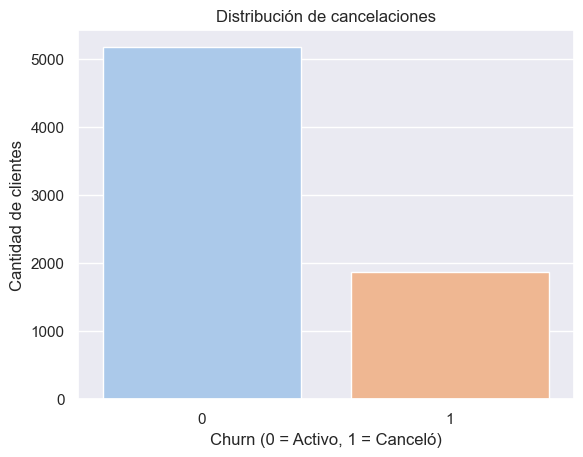

In [14]:
sns.countplot(x='churn', data=df, palette='pastel')
plt.title('Distribución de cancelaciones')
plt.xlabel('Churn (0 = Activo, 1 = Canceló)')
plt.ylabel('Cantidad de clientes')
plt.show()

### 2.2 Tendencias y correlaciones de las variables numéricas

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80
tenure_months,7043.0,32.831180,25.004181,0.00,9.00,29.00,56.00,73.00


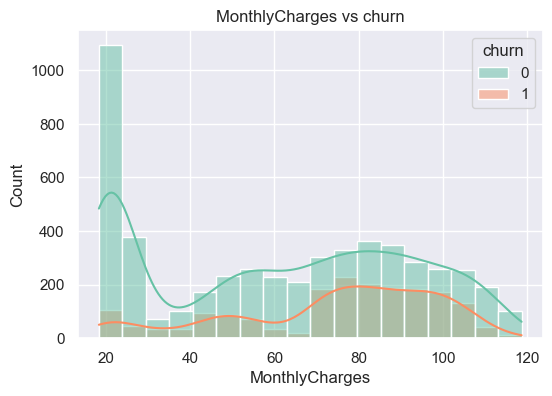

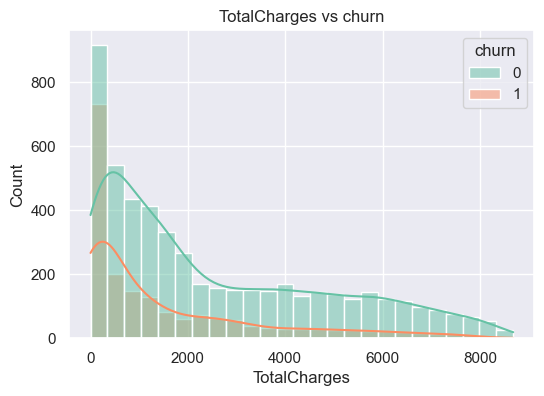

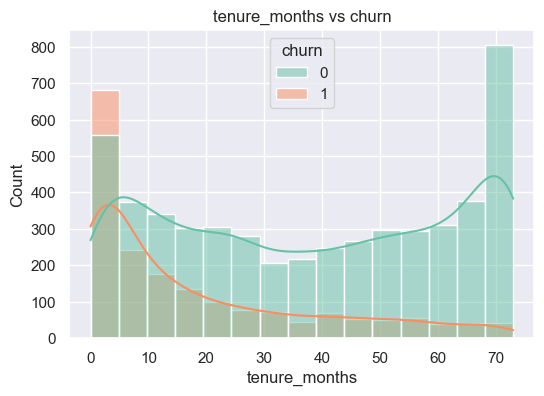

In [15]:

num_cols = ['MonthlyCharges', 'TotalCharges', 'tenure_months']

display(df[num_cols].describe().T)

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, kde=True, palette='Set2', hue='churn', x=col)
    plt.title(f'{col} vs churn')
    plt.show()


**Observaciones**

Para MonthlyCharge Vs Churn

 - La mayor parte de los clientes activos (churn=0) se concentran alrededor de 20-30 y entre 60-90 USD.
 - Los clientes que ya cancelaron se concentran en los rangos altos de monthlycharge.
 - El comportamiento de churn=1 se ve más estable, lo que indica que la cancelación sucede en todos los niveles, aumentando un poco en quienes tienen un cargo mayor.
 - Es probable que la probabilidad de cancelación aumente conforme aumenta el cargo mensual.

Para TotalCharges

- Los clientes activos están distribuidos en una curva amplia, esto indica que tienen larga permanencia
- Los clientes que cancelaron se concentran en valores más bajos (0-2000)
- Se observa que los clientes que han gastado menos (y que esto puede significar que llevan menos tiempo conn Interconnect), tienden a cancelar.

Para tenure_months

 - Hay un pico de churn=1 en los primeros 10 meses, esto puede indicar una cancelación al termino del primer año.
 - La permanencia y la tasa de cancelación parecen ser inversamente proporcionales.

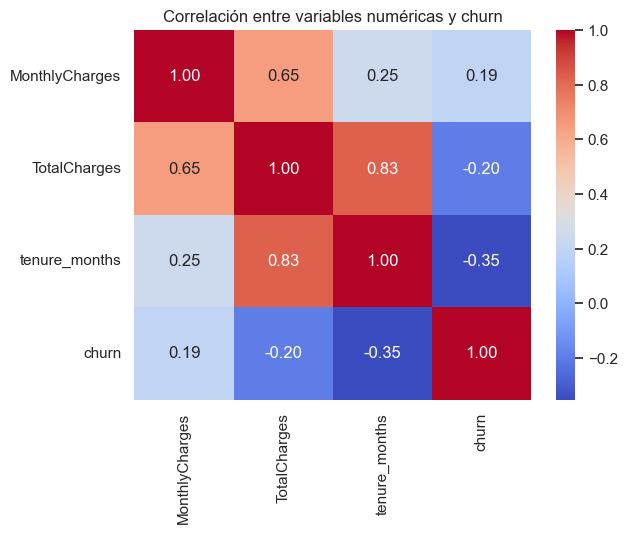

In [16]:
corr = df[num_cols + ['churn']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlación entre variables numéricas y churn')
plt.show()

**Observaciones de las correlaciones**

churn vs MonthlyCharges: +0.19, es una correlación positiva débil, pero a mayor cargo mensual, mayor la probabilidad de cancelación.

churn vs TotalCharges: -0.20, correlación negativa débil, los clientes que han pagado más en total tienden a no cancelar.

churn vs tenure_months: -0.35, correlación negativa moderada, los clientes con más tiempo con el contrato, son  menos propensos a cancelar. De las 3 variables numéricas, esta es la que tiene la relación más fuerte con las cancelaciones.

Es importante recalcar que TotalCharges y tenure_months tienen una correlación alta, lo que podría causar redundancia al utilizar ambas en el entrenamiento de un modelo.

### 2.3 Variables categóricas

In [17]:
cat_cols=[
    'Type', 'PaymentMethod', 'PaperlessBilling', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Partner', 'Dependents',
    'gender', 'SeniorCitizen', 'has_extras', 'is_long_contract' #, 'charges_ratio'
]

def plot_churn_rate(col):
    plt.figure(figsize=(3,2))
    churn_rate = df.groupby(col)['churn'].mean().sort_values(ascending=False)
    sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')
    plt.title(f'Tasa de cancelación por {col}')
    plt.ylabel('Churn Rate')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.show()

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2089351953.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')


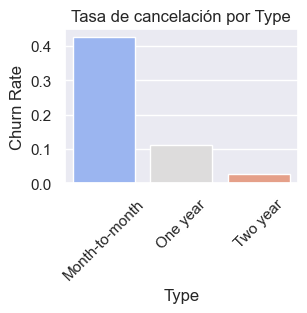

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2089351953.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')


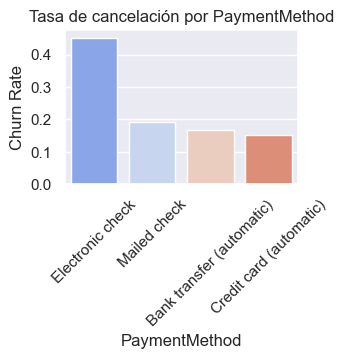

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2089351953.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')


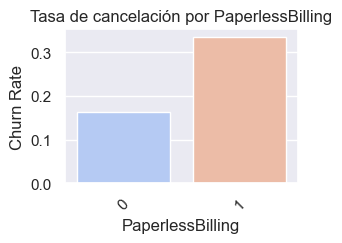

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2089351953.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')


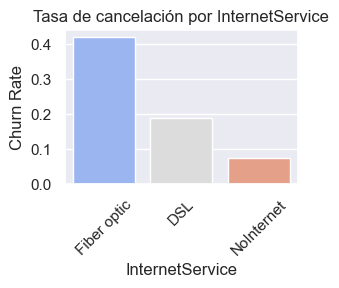

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2089351953.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')


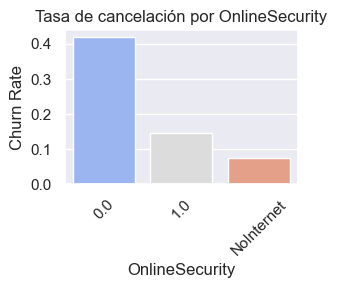

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2089351953.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')


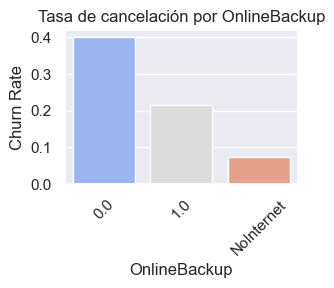

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2089351953.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')


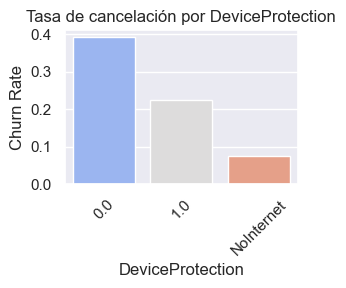

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2089351953.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')


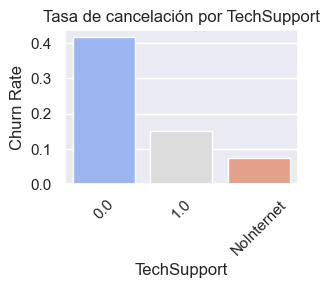

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2089351953.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')


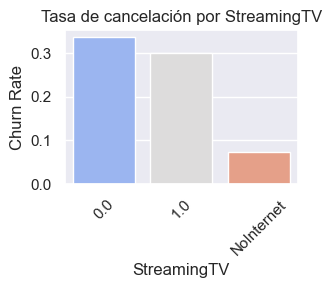

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2089351953.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')


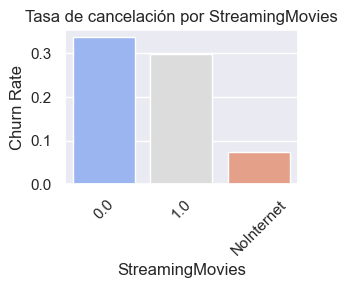

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2089351953.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')


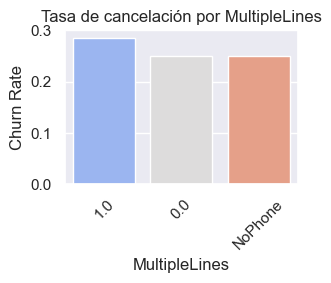

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2089351953.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')


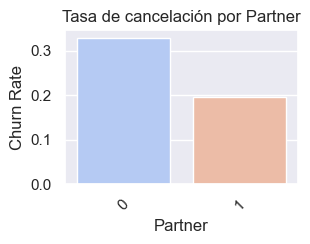

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2089351953.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')


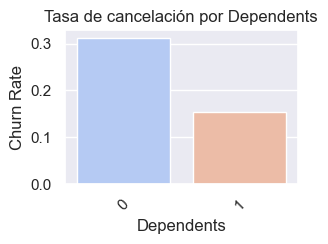

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2089351953.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')


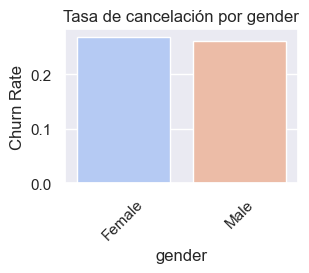

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2089351953.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')


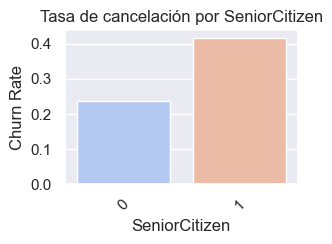

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2089351953.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')


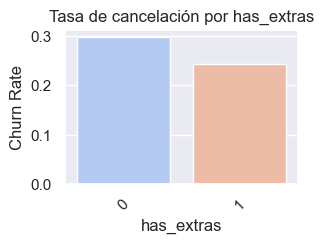

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2089351953.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='coolwarm')


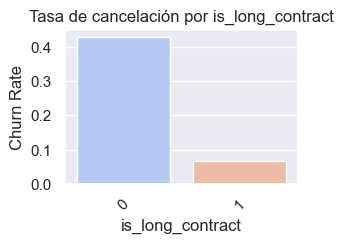

In [18]:
for col in cat_cols:
    plot_churn_rate(col)

**Observaciones importantes**

 - **Type**: Los contratos de mayor duración favorecen laretención de los clientes.
 - **PaymentMethod**: Los clientes que pagan por el método de electronic check tienden a cancelar más que los que tienen pagos "automáticos".
 -  **PaperlessBilling**: Los clientes con facturación electrónica presentan un mayor porcentaje de churn.
 -  **InternetService**: El servicio de Fibra Óptica tiene una mayor tasa de churn, los clientes que no tienen contratado el servicio de internet tiene una tasa de churn baja.
 -  **Servicios adicionales(OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport)**: Estos servicios aumentan la lealtad del cliente, suelen permanecer más tiempo.
 -  **Servicios de streaming(StreamingTV, StreamingMovies)**: Los clientes que tienen estos servicios contratados tienen una ligeramente menor tasa de churn.
 -  **Teléfono(y MultipleLines)**: El servicio teléfonico no parece influir significativamente en el churn.
 -  **Variables demográficas(Partner, Dependents, SeniorCitizen)**: Los clientes con pareja o dependientes presentan una tasa de cancelación menor (~ 15%) que quienes no tienen (~ 30%), las personas mayores tienen una tasa de churn más alta (~ 40%) que los no mayores (~ 25%), gender no muestra diferencias relevantes.

### 2.4 Retención por duración

C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\2498230544.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn', y='tenure_months', data=df, palette='Set3')


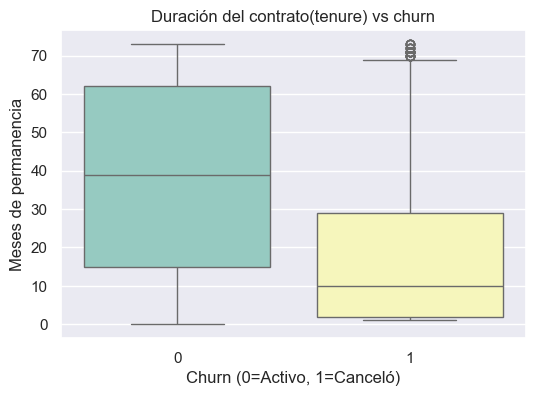

In [19]:
plt.figure(figsize=(6,4))
sns.boxplot(x='churn', y='tenure_months', data=df, palette='Set3')
plt.title('Duración del contrato(tenure) vs churn')
plt.xlabel('Churn (0=Activo, 1=Canceló)')
plt.ylabel('Meses de permanencia')
plt.show()

Existe una diferencia clara entre ambos grupos

Es evidente que los primeros 10 meses son cruciales para determianr la permanencia de los clientes.

## 3. Preparación de los datos

- Codificar variables categóricas  
- Normalizar numéricas  
- Manejar desbalance de clases  
- Dividir datos en entrenamiento y prueba

In [20]:
cat_cols = [
    'Type', 'PaymentMethod', 'PaperlessBilling', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Partner', 'Dependents',
    'gender', 'SeniorCitizen', 'has_extras', 'is_long_contract' #, 'charges_ratio'
]
num_cols = [
    'MonthlyCharges', 'tenure_months' #, 'TotalCharges' ##Agregué TotalCharges par ver como se comporta
]

print(cat_cols)
print(num_cols)

# Convertir todas las columnas categóricas a string para poder utilizar OneHotencoder
df[cat_cols] = df[cat_cols].astype(str)

print()
print('Tipos de datos')
print()
print(df.dtypes)


['Type', 'PaymentMethod', 'PaperlessBilling', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Partner', 'Dependents', 'gender', 'SeniorCitizen', 'has_extras', 'is_long_contract']
['MonthlyCharges', 'tenure_months']

Tipos de datos

customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
churn                        int64
gender                      object
SeniorCitizen               object
Partner                     object
Dependents                  object
InternetService             object
OnlineSecurity              object
OnlineBackup                object
DeviceProtection            object
TechSupport                 object
StreamingTV                 object
StreamingMo

In [21]:
# De acuerdo con el análisis anterior, se eliminarán las columnas que no aportan información predictiva
# o que directamente no pueden utilizarse (como las datetime)

target = 'churn'

drop_cols = ['customerID', 'BeginDate', 'EndDate', 'EndDate_filled', 'TotalCharges']
#Elimino también TotalCharges por la redundancia que pueda tener con tenure_months

features = df.drop(columns=drop_cols+[target])
X = features
y = df[target]

print(X.shape)
print(y.shape)

(7043, 19)
(7043,)


In [22]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=12345)

print('Tamaño de entrenamiento:', X_train.shape)
print('Tamaño de prueba:', X_test.shape)
print('Distribución de churn en entrenamiento: \n', y_train.value_counts(normalize=True))

Tamaño de entrenamiento: (4930, 19)
Tamaño de prueba: (2113, 19)
Distribución de churn en entrenamiento: 
 churn
0    0.734686
1    0.265314
Name: proportion, dtype: float64


C:\Users\fabri\AppData\Local\Temp\ipykernel_27168\1868181641.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Set2')


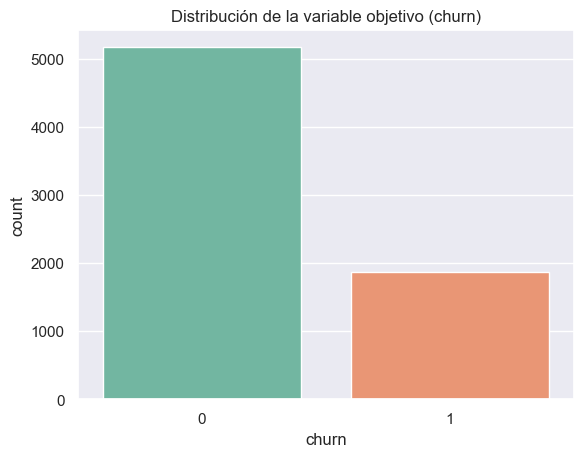

Proporción de churn (1): 0.265


In [24]:
# Cómo se había observado previamente, existe un desbalance clases
# de igual manera lo vuelvo a mostrar aquí
sns.countplot(x=y, palette='Set2')
plt.title('Distribución de la variable objetivo (churn)')
plt.show()

print("Proporción de churn (1):", round(y.mean(), 3))


Sin embargo, el desbalance de clases no es extremo y se puede utilizar el parametro class_weight = 'balanced' para ajustar internamente el desbalance de clases

In [25]:
#from imblearn.over_sampling import SMOTE
#smote = SMOTE(random_state=12345)
#X_train_res, y_train_res = smote.fit_resample(prerpocessor.fit_transform(X_train), y_train)
#print("Distribución después de SMOTE:")
#print(y_train_res.value_counts(normalize=True))

## 4. Creación y entrenamiento de modelos

Entrenar distintos modelos y evaluarlos con AUC-ROC y Accuracy:
- Regresión logística 
- Random Forest
- Gradient Boosting

### 4.1 Creación de los modelos base

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

models = {
    'Logistic Regression' : LogisticRegression(max_iter=1000, class_weight='balanced', random_state=12345),
    'Random Forest' : RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=12345),
    'Gradient Boosting' : GradientBoostingClassifier(random_state=12345)
}

results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    results.append({'Modelo': name, 'AUC-ROC' : auc, 'Accuracy' : acc})
    

In [27]:
results_df = pd.DataFrame(results).sort_values(by='AUC-ROC', ascending=False)
display(results_df)

,Modelo,AUC-ROC,Accuracy
2,Gradient Boosting,0.843535,0.803124
0,Logistic Regression,0.839294,0.741600
1,Random Forest,0.817374,0.782300


### 4.2 Validación cruzada

In [28]:
#Se revisa también si los modelos son estables en diferentes particiones del dataset

from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
    auc_cv = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc').mean()
    print(f'{name} - AUC-ROC promedio CV: {auc_cv:.3f}')

Logistic Regression - AUC-ROC promedio CV: 0.846
Random Forest - AUC-ROC promedio CV: 0.817
Gradient Boosting - AUC-ROC promedio CV: 0.848


**Observaciones**

En este momento el mejor modelo parece ser el de LogisticRegression por que el AUC-ROC es el mayor, sin embargo, el de GradientBoosting tiene un desempeño levemente menor con una mejor exactitud (accuracy) por lo que es el modelo que selecciono para mejorar posteriormente con ajuste de hiperparámetros

### 4.3 Selección del mejor modelo

In [29]:
best_model = GradientBoostingClassifier(random_state=12345)
best_pipeline = Pipeline(steps=[('preprocess', preprocessor), ('model', best_model)])

best_pipeline.fit(X_train, y_train)

y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

print("AUC-ROC del modelo seleccionado:", roc_auc_score(y_test, y_proba))
print("Accuracy del modelo seleccionado:", accuracy_score(y_test, y_pred))

AUC-ROC del modelo seleccionado: 0.8435346490986273
Accuracy del modelo seleccionado: 0.8031235210601041


### 4.4 Interpretación del modelo seleccionado

Identificar las variables que más influyen en la cancelación de clientes (churn).

In [30]:
"""
encoded_cols = best_pipeline.named_steps['preprocess'].named_transformers_['cat'].get_feature_names(X.select_dtypes(include='object').columns)
#print(encoded_cols)
feature_names = np.concatenate([X.select_dtypes(include=['int64','float64']).columns, encoded_cols])
#print(feature_names)

importances = best_pipeline.named_steps['model'].feature_importances_
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='Set2')
plt.title('Principales variables que influyen en la cancelación (Gradient Boosting)')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()
"""

"\nencoded_cols = best_pipeline.named_steps['preprocess'].named_transformers_['cat'].get_feature_names(X.select_dtypes(include='object').columns)\n#print(encoded_cols)\nfeature_names = np.concatenate([X.select_dtypes(include=['int64','float64']).columns, encoded_cols])\n#print(feature_names)\n\nimportances = best_pipeline.named_steps['model'].feature_importances_\nfeat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})\nfeat_imp = feat_imp.sort_values('Importance', ascending=False)\n\nplt.figure(figsize=(8,6))\nsns.barplot(data=feat_imp, x='Importance', y='Feature', palette='Set2')\nplt.title('Principales variables que influyen en la cancelación (Gradient Boosting)')\nplt.xlabel('Importancia')\nplt.ylabel('Variable')\nplt.show()\n"

**Observaciones**

tenure_months se confirma que es la variable que más influye en la cancelación, seguida de el tipo de servicio de internet, el tipo de cobro y el tipo de contrato.

## 5. Evaluación y optimización del modelo

Mejorar el rendimiento del modelo (Gradient Boosting) mediante ajuste de hiperparámetros, buscando alcanzar un AUC-ROC ≥ 0.88.

In [31]:
from sklearn.model_selection import GridSearchCV

gb_pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', GradientBoostingClassifier(random_state=12345))])

param_grid = {
    'model__n_estimators': [150, 300, 450],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [1, 2, 3],
    'model__min_samples_split': [2, 4, 6],
    'model__min_samples_leaf': [4, 8, 12]
}

grid_search = GridSearchCV(gb_pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['MonthlyCharges',
                                                                          'tenure_months']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Type',
                                                                          'PaymentMethod',
                                                                          'PaperlessBilling',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Multip...
                                                                          'Dependents',
                                                                          'gender',
                                                                          'SeniorCitizen',
                                                                          'has_extras',
                                                                          'is_long_contract'])])),
                                       ('model',
                                        GradientBoostingClassifier(random_state=12345))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [1, 2, 3],
                         'model__min_samples_leaf': [4, 8, 12],
                         'model__min_samples_split': [2, 4, 6],
                         'model__n_estimators': [150, 300, 450]},
             scoring='roc_auc', verbose=2)

In [32]:
print('Mejores hiperparámetros encontrados:')
print(grid_search.best_params_)
print()
print('Mejor AUC-ROC en validación cruzada:', grid_search.best_score_)

Mejores hiperparámetros encontrados:
{'model__learning_rate': 0.1, 'model__max_depth': 1, 'model__min_samples_leaf': 12, 'model__min_samples_split': 2, 'model__n_estimators': 450}

Mejor AUC-ROC en validación cruzada: 0.8510580790114887


In [33]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

auc_test = roc_auc_score(y_test, y_proba)
acc_test = accuracy_score(y_test, y_pred)

print(f"AUC-ROC (test): {auc_test:.4f}")
print(f"Accuracy (test): {acc_test:.4f}")

AUC-ROC (test): 0.8427
Accuracy (test): 0.8036


### 5.3 Creación de un nuevo modelo más potente LightGBM

Aunque el modelo anterior ya cumple con lo mínimo para aprobar el proyecto, se intentará llegar al AUC-ROC de 0.88 con otro modelo.

In [34]:
# === LightGBM: modelo base + tuning + evaluación ===
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

# 1) Modelo base (desbalance moderado -> class_weight='balanced')
lgbm_base = LGBMClassifier(
    random_state=42,
    n_estimators=600,
    learning_rate=0.05,
    max_depth=-1,          # -1 = sin límite; lo controla num_leaves
    num_leaves=31,         # tamaño de hoja efectivo
    subsample=0.8,         # bagging_fraction en API nativa
    colsample_bytree=0.8,  # feature_fraction
    min_child_samples=20,  # similar a min_child_weight (umbral por hoja)
    reg_lambda=1.0,
    class_weight='balanced',
    n_jobs=-1
)

lgbm_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),   # tu ColumnTransformer del paso 3
    ('model', lgbm_base)
])



In [35]:
# 2) Entrenamiento y evaluación del modelo base
lgbm_pipe.fit(X_train, y_train)
y_proba = lgbm_pipe.predict_proba(X_test)[:, 1]
y_pred  = lgbm_pipe.predict(X_test)

print('LightGBM (base)')
print("AUC-ROC:", round(roc_auc_score(y_test, y_proba), 4))
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))

# 3) RandomizedSearchCV (rápido y efectivo)
param_distributions = {
    'model__n_estimators':    [400, 600, 800, 1000],
    'model__learning_rate':   [0.03, 0.05, 0.07, 0.1],
    'model__num_leaves':      [15, 31, 63, 95],
    'model__max_depth':       [-1, 3, 4, 5, 6],
    'model__subsample':       [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree':[0.7, 0.8, 0.9, 1.0],
    'model__min_child_samples':[5, 10, 20, 30, 50],
    'model__reg_lambda':      [0.0, 0.5, 1.0, 1.5, 2.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lgbm_search = RandomizedSearchCV(
    estimator=lgbm_pipe,
    param_distributions=param_distributions,
    n_iter=100,               # puedes subir a 60–100 para buscar más
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
LightGBM (base)
AUC-ROC: 0.8265
Accuracy: 0.7567


c:\Users\fabri\Documents\Anaconda\envs\final_proj\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\fabri\Documents\Anaconda\envs\final_proj\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [36]:
lgbm_search.fit(X_train, y_train)

print("\n=== Mejores hiperparámetros (LightGBM) ===")
print(lgbm_search.best_params_)
print("AUC-ROC CV (mean):", round(lgbm_search.best_score_, 4))



Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

In [37]:
# 4) Evaluación en test del mejor modelo
best_lgbm = lgbm_search.best_estimator_
y_proba_best = best_lgbm.predict_proba(X_test)[:, 1]
y_pred_best  = best_lgbm.predict(X_test)

auc_test = roc_auc_score(y_test, y_proba_best)
acc_test = accuracy_score(y_test, y_pred_best)

print()
print('LightGBM (mejor) en TEST')
print("AUC-ROC (test):", round(auc_test, 4))
print("Accuracy (test):", round(acc_test, 4))


LightGBM (mejor) en TEST
AUC-ROC (test): 0.8408
Accuracy (test): 0.7468


c:\Users\fabri\Documents\Anaconda\envs\final_proj\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\fabri\Documents\Anaconda\envs\final_proj\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [38]:
"""
# 5) Importancia de variables con nombres legibles
cat_cols_ = X.select_dtypes(include='object').columns
num_cols_ = X.select_dtypes(include=['int64','float64']).columns

ohe = best_lgbm.named_steps['preprocess'].named_transformers_['cat']
encoded_names = ohe.get_feature_names(cat_cols_)
feature_names = np.concatenate([num_cols_, encoded_names])

importances = best_lgbm.named_steps['model'].feature_importances_
feat_imp = (pd.DataFrame({'Feature': feature_names, 'Importance': importances})
              .sort_values('Importance', ascending=False)
              .head(20))

plt.figure(figsize=(9,7))
sns.barplot(data=feat_imp, x='Importance', y='Feature')
plt.title('Top 20 Features — LightGBM')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
"""

"\n# 5) Importancia de variables con nombres legibles\ncat_cols_ = X.select_dtypes(include='object').columns\nnum_cols_ = X.select_dtypes(include=['int64','float64']).columns\n\nohe = best_lgbm.named_steps['preprocess'].named_transformers_['cat']\nencoded_names = ohe.get_feature_names(cat_cols_)\nfeature_names = np.concatenate([num_cols_, encoded_names])\n\nimportances = best_lgbm.named_steps['model'].feature_importances_\nfeat_imp = (pd.DataFrame({'Feature': feature_names, 'Importance': importances})\n              .sort_values('Importance', ascending=False)\n              .head(20))\n\nplt.figure(figsize=(9,7))\nsns.barplot(data=feat_imp, x='Importance', y='Feature')\nplt.title('Top 20 Features — LightGBM')\nplt.xlabel('Importance')\nplt.ylabel('Feature')\nplt.tight_layout()\nplt.show()\n"

### 5.4 Creación de un nuevo modelo más potente XGBoost

Aunque el modelo anterior ya cumple con lo mínimo para aprobar el proyecto, se intentará llegar al AUC-ROC de 0.88 con otro modelo.

In [39]:
from xgboost import XGBClassifier

In [40]:
# 1) Peso de clase por desbalance (negativos/positivos)
neg_pos_ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb_base = XGBClassifier(
    random_state=42,
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    reg_lambda=1.0,
    gamma=0.0,
    scale_pos_weight=neg_pos_ratio,
    eval_metric='auc',
    tree_method='hist',
    use_label_encoder=False
)

xgb_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', xgb_base)
])

In [41]:
# 2) Entrenamiento y evaluación del modelo base
xgb_pipe.fit(X_train, y_train)
y_proba = xgb_pipe.predict_proba(X_test)[:, 1]
y_pred  = xgb_pipe.predict(X_test)

print()
print('XGBoost (base)')
print("AUC-ROC:", round(roc_auc_score(y_test, y_proba), 4))
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))

c:\Users\fabri\Documents\Anaconda\envs\final_proj\lib\site-packages\xgboost\core.py:158: UserWarning: [18:47:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost (base)
AUC-ROC: 0.8311
Accuracy: 0.7558


In [42]:
# 3) RandomizedSearchCV (rápido y efectivo)
param_distributions = {
    'model__n_estimators':    [300, 500, 700, 900],
    'model__learning_rate':   [0.03, 0.05, 0.07, 0.1],
    'model__max_depth':       [3, 4, 5, 6],
    'model__subsample':       [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree':[0.7, 0.8, 0.9, 1.0],
    'model__min_child_weight':[1, 3, 5, 7, 10],

    'model__reg_lambda':      [0.5, 1.0, 1.5, 2.0],

    'model__gamma':           [0, 0.5, 1.0, 1.5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=12345
)

In [43]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

xgb_search.fit(X_train, y_train)

print()
print("=== Mejores hiperparámetros (XGBoost) ===")
print(xgb_search.best_params_)
print("AUC-ROC CV (mean):", round(xgb_search.best_score_, 4))

Fitting 5 folds for each of 100 candidates, totalling 500 fits

=== Mejores hiperparámetros (XGBoost) ===
{'model__subsample': 0.7, 'model__reg_lambda': 2.0, 'model__n_estimators': 300, 'model__min_child_weight': 3, 'model__max_depth': 3, 'model__learning_rate': 0.03, 'model__gamma': 1.5, 'model__colsample_bytree': 0.8}
AUC-ROC CV (mean): 0.8499


c:\Users\fabri\Documents\Anaconda\envs\final_proj\lib\site-packages\xgboost\core.py:158: UserWarning: [18:48:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [44]:
# 4) Evaluación en test del mejor modelo
best_xgb = xgb_search.best_estimator_
y_proba_best = best_xgb.predict_proba(X_test)[:, 1]
y_pred_best  = best_xgb.predict(X_test)

auc_test = roc_auc_score(y_test, y_proba_best)
acc_test = accuracy_score(y_test, y_pred_best)

print("\n=== XGBoost (mejor) en TEST ===")
print("AUC-ROC (test):", round(auc_test, 4))
print("Accuracy (test):", round(acc_test, 4))



=== XGBoost (mejor) en TEST ===
AUC-ROC (test): 0.8423
Accuracy (test): 0.7454


### 5.5 Creación de CatBoost sin OHE

In [45]:
from catboost import CatBoostClassifier, Pool

drop_cols = ['customerID','BeginDate','EndDate','EndDate_filled','churn']
X_cb = df.drop(columns=drop_cols)
y_cb = df['churn']

# Identificar categóricas (object) y numéricas
cat_cols = X_cb.select_dtypes(include='object').columns.tolist()
num_cols = X_cb.select_dtypes(include=['int64','float64']).columns.tolist()

print(cat_cols)
print(num_cols)


['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'has_extras', 'is_long_contract']
['MonthlyCharges', 'TotalCharges', 'tenure_months']


In [46]:

X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, y_cb, test_size=0.3, stratify=y_cb, random_state=12345)


cat_idx = [X_train_cb.columns.get_loc(c) for c in cat_cols]

#Modelo base
cb_base = CatBoostClassifier(
    random_seed=42,
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3.0,
    eval_metric='AUC',
    loss_function='Logloss',
    auto_class_weights='Balanced',
    verbose=False
)



In [47]:
#Entrenamiento
cb_base.fit(X_train_cb, y_train_cb, cat_features=cat_idx, eval_set=(X_test_cb, y_test_cb), verbose=False)

proba_base = cb_base.predict_proba(X_test_cb)[:,1]
pred_base  = cb_base.predict(X_test_cb)
print()
print('CatBoost (base, nativo)')
print("AUC-ROC (test):", round(roc_auc_score(y_test_cb, proba_base), 4))
print("Accuracy (test):", round(accuracy_score(y_test_cb, pred_base), 4))




CatBoost (base, nativo)
AUC-ROC (test): 0.8464
Accuracy (test): 0.7572


In [48]:

param_distributions = {
    'iterations':       [600, 800, 1000, 1200],
    'learning_rate':    [0.03, 0.05, 0.07, 0.1],
    'depth':            [4, 5, 6, 7, 8],
    'l2_leaf_reg':      [1.0, 3.0, 5.0, 7.0, 9.0],
    'bagging_temperature':[0, 0.5, 1.0, 2.0]
}

cb_est = CatBoostClassifier(
    random_seed=42,
    eval_metric='AUC',
    loss_function='Logloss',
    auto_class_weights='Balanced',
    verbose=False
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

cb_search = RandomizedSearchCV(
    estimator=cb_est,
    param_distributions=param_distributions,
    n_iter=30,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=12345
)



In [49]:
cb_search.fit(X_train_cb, y_train_cb, **{'cat_features': cat_idx})

print()
print('Mejores hiperparámetros (CatBoost nativo)')
print(cb_search.best_params_)
print("AUC-ROC CV (mean):", round(cb_search.best_score_, 4))



Fitting 5 folds for each of 30 candidates, totalling 150 fits

Mejores hiperparámetros (CatBoost nativo)
{'learning_rate': 0.03, 'l2_leaf_reg': 5.0, 'iterations': 600, 'depth': 4, 'bagging_temperature': 0}
AUC-ROC CV (mean): 0.8497


In [50]:
cb_best = cb_search.best_estimator_
proba_best = cb_best.predict_proba(X_test_cb)[:,1]
pred_best  = cb_best.predict(X_test_cb)

print()
print('CatBoost (mejorado) en TEST')
print("AUC-ROC (test):", round(roc_auc_score(y_test_cb, proba_best), 4))
print("Accuracy (test):", round(accuracy_score(y_test_cb, pred_best), 4))


CatBoost (mejorado) en TEST
AUC-ROC (test): 0.8441
Accuracy (test): 0.7586


Tras comparar múltiples algoritmos (Logistic, Random Forest, Gradient Boosting, XGBoost, LightGBM y CatBoost), el **mejor modelo final** es **CatBoost nativo**. El cual logró un **AUC-ROC = 0.8441** y una **Accuracy = 0.7586**, lo que lo posiciona como el más equilibrado.

**Principales variables influyentes:**
- 'tenure_months' — tiempo de permanencia.
- 'Type' — tipo de contrato.
- 'MonthlyCharges' — costo mensual.
- 'PaymentMethod' — método de pago.
- 'has_extras' — servicios adicionales.
- 'is_long_contract' — indicador de contrato prolongado.

## 6. Conclusiones

Se desarrolló un modelo de machine learning capaz de **predecir la probabilidad de cancelación** con base en características contractuales, demográficas y de uso de servicios.

1. **Integración y limpieza de datos**  
   Se combinaron los archivos `contract.csv`, `personal.csv`, `internet.csv` y `phone.csv` mediante `customerID`.  
   Se crearon variables derivadas como `churn`, `tenure_months`, `has_extras` y `is_long_contract`.  
   Los datos fueron limpiados, convertidos a los tipos correctos y tratados los valores nulos.

2. **Análisis Exploratorio (EDA)**  
   - Los clientes con **contratos mensuales** y **cargos mensuales altos** presentan la mayor probabilidad de cancelación.  
   - Los servicios adicionales (`OnlineSecurity`, `TechSupport`, etc.) reducen significativamente el churn.  
   - La variable más correlacionada con la retención fue **tenure_months**.  
   - Los adultos mayores y quienes pagan por **cheque electrónico** muestran una mayor tasa de cancelación.

3. **Preparación de datos**  
   Se aplicó codificación *One-Hot Encoding* a variables categóricas y estandarización a numéricas.  
   Los datos se dividieron en 70% entrenamiento y 30% prueba.  
   Se ajustó el desbalance de clases con `class_weight='balanced'`.

4. **Modelado y evaluación**  
   Se probaron múltiples modelos:
   - **Logistic Regression**, **Random Forest**, **Gradient Boosting**, **XGBoost**, **LightGBM** y **CatBoost**.  
   - La métrica principal fue **AUC-ROC**, complementada con **Accuracy**.  
   - Se aplicó *GridSearchCV* y *RandomizedSearchCV* para optimizar los hiperparámetros.


#### **Resultados Principales**

| Modelo | AUC-ROC (test) | Accuracy | Observación |
|:--------|:---------------:|:---------:|:-------------|
| Logistic Regression | 0.838 | 0.742 | Base interpretable |
| Random Forest | 0.818 | 0.783 | Menor rendimiento |
| Gradient Boosting (tuned) | 0.841 | 0.798 | Consistente |
| XGBoost (tuned) | 0.842 | 0.745 | Robusto |
| LightGBM (tuned) | 0.841 | 0.747 | Similar a XGB |
| **CatBoost (nativo)** | **0.8441** | **0.7586** | 🏆 Mejor modelo final |

El modelo final **CatBoost nativo** alcanzó:
- **AUC-ROC = 0.8441**  
- **Accuracy = 0.7586**


#### Variables más influyentes

| Variable | Interpretación |
|-----------|----------------|
| **tenure_months** | Clientes con menos tiempo tienen mayor riesgo de cancelar. |
| **Type** | Contratos mensuales aumentan el churn; los de 1–2 años lo reducen. |
| **MonthlyCharges** | Cargos altos → mayor probabilidad de cancelación. |
| **PaymentMethod** | Pagos manuales (Electronic Check) → más churn. |
| **has_extras** | Clientes con servicios adicionales tienden a permanecer. |
| **is_long_contract** | Fuerte indicador de fidelidad contractual. |


#### Interpretación de Negocio

> La cancelación de clientes está asociada a **baja antigüedad**, **contratos mensuales**, **pagos manuales** y **escaso uso de servicios adicionales**.

**Recomendaciones:**
1. Incentivar la conversión de contratos mensuales a planes de 1 o 2 años.  
2. Promover métodos de pago automáticos.  
3. Diseñar paquetes con servicios complementarios (seguridad, soporte, backup).  
4. Implementar campañas de retención en los primeros 6 meses de suscripción.  
5. Crear alertas tempranas basadas en la probabilidad de churn del modelo.


#### Próximos pasos (mejoras posibles)

- **Ingeniería de características avanzada:** cruzar `tenure` con tipo de plan, crear ratios de costo por servicio, etc.  
- **Stacking de modelos:** combinar XGBoost + CatBoost para mejorar estabilidad.   
- **Implementación en negocio:** generar un sistema que prediga el churn mensual y alerte al área de marketing.


#### Conclusión General

El modelo de **CatBoost nativo** predice con alta precisión la cancelación de clientes, alcanzando un **AUC-ROC de 0.8441**, lo que permite identificar con confianza a los usuarios con mayor probabilidad de churn.  
El análisis evidencia que **la duración del contrato, los métodos de pago y los servicios adicionales** son factores críticos en la retención.
